### Import Liabraries

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

### Load Dataset

In [109]:
df=pd.read_csv('PS_20174392719_1491204439457_log.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Basic information about the columns
* Time step (could be hours, minutes, etc.). Sequential unit showing when the transaction happened.
* type	Type of transaction. 
1. PAYMENT: Payment to a merchant
2. TRANSFER: Transfer between accounts
3.  CASH_OUT: Withdrawal by cash
4.  Others: DEBIT, CASH_IN
* amount	Amount of money involved in the transaction.
* nameOrig	The customer ID of the person/account initiating the transaction. Starts with "C".
* oldbalanceOrg	Account balance of the initiator before the transaction.
* newbalanceOrig	Account balance of the initiator after the transaction.
* nameDest	The recipient ID of the transaction.
1. "C..." means it's a customer
2. "M..." means it's a merchant.
* oldbalanceDest	Account balance of the recipient before the transaction.
* newbalanceDest	Account balance of the recipient after the transaction.
* isFraud	Target column.
1. 1 = Fraudulent Transaction
2. 0 = Legitimate Transaction
* isFlaggedFraud	Flagged by the system as suspicious.
1. 1 = System flagged it
2. 0 = System didn’t flag

In [110]:
df.sample(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
3547427,260,PAYMENT,8402.91,C207175348,948851.00,940448.09,M617216415,0.00,0.00,0,0
4807668,346,PAYMENT,4600.01,C663883131,23623.56,19023.55,M1991352069,0.00,0.00,0,0
395806,18,CASH_IN,57252.76,C1166082569,453478.34,510731.10,C1990763345,78946.30,21693.54,0,0
3426710,256,CASH_OUT,144570.57,C1044507814,0.00,0.00,C238707653,4095708.52,4240279.09,0,0
4976708,352,CASH_OUT,328914.92,C680299313,20304.00,0.00,C1680466547,0.00,328914.92,0,0


### EDA

In [111]:
df.shape

(6362620, 11)

In [112]:
df['type'].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

In [113]:
# checking  impossible observations
((df['type'].isin(['PAYMENT','CASH_OUT','TRANSFER','DEBIT'])) & (df['amount'] > df['oldbalanceOrg'])).sum()

3601544

In [114]:
impossible_observations = ((df['type'].isin(['PAYMENT','CASH_OUT','TRANSFER','DEBIT'])) & (df['amount'] > df['oldbalanceOrg']))

In [115]:
df[impossible_observations].shape

(3601544, 11)

In [116]:
df[impossible_observations]['isFraud'].sum()

29

In [117]:
(df[impossible_observations]['isFraud'].sum()/df.shape[0])*100

0.00045578708142243296

In [118]:
df['isFraud'].sum()

8213

In [119]:
# remove impossible obseravations
df = df[~((df['type'].isin(['PAYMENT','CASH_OUT','TRANSFER','DEBIT'])) & (df['amount'] > df['oldbalanceOrg']))]

In [120]:
df.sample(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2482850,204,PAYMENT,6175.84,C522916184,80250.00,74074.16,M1054666477,0.00,0.00,0,0
5209318,370,PAYMENT,8202.26,C1945469734,235719.00,227516.74,M1710516137,0.00,0.00,0,0
4090261,301,CASH_IN,123673.98,C2045184490,4113564.31,4237238.29,C1469593986,564637.91,440963.93,0,0
5986453,408,PAYMENT,6863.19,C1461292953,10516.00,3652.81,M1868871438,0.00,0.00,0,0
3497189,259,CASH_IN,37159.84,C946384224,8053304.87,8090464.71,C103841323,801870.83,764711.00,0,0


In [121]:
df.shape

(2761076, 11)

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2761076 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 252.8+ MB


In [123]:
# create a new hour column from step
df['hour'] = (df['step']-1)%24

In [124]:
# here 0 mean 12 am to 1 am
# 1 mean 1 am to 2 am
# and so on
# 23 mean 11pm to 12pm

In [125]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0


In [126]:
df=df.drop(columns='step')

In [127]:
total_by_hour=df.groupby('hour').size()
fraud_by_hour=df[df['isFraud']==1].groupby('hour').size()
(fraud_by_hour/total_by_hour)*100

hour
0      2.251312
1      6.004843
2     23.743627
3     30.648770
4     30.298013
5     16.791745
6      6.438948
7      2.694941
8      0.276779
9      0.208693
10     0.174189
11     0.169879
12     0.179163
13     0.190081
14     0.192437
15     0.186642
16     0.193586
17     0.139445
18     0.120827
19     0.134777
20     0.287337
21     0.355160
22     0.421444
23     0.758476
dtype: float64

In [128]:
df.describe()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour
count,2.761076e+06,2.761076e+06,2.761076e+06,2.761076e+06,2.761076e+06,2.761076e+06,2.761076e+06,2.761076e+06
mean,1.034841e+05,1.902767e+06,1.970523e+06,9.385120e+05,8.906475e+05,2.964062e-03,5.794842e-06,1.473075e+01
std,1.935515e+05,4.147579e+06,4.183875e+06,2.967796e+06,2.961877e+06,5.436246e-02,2.407241e-03,4.257089e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.187920e+03,3.149500e+04,4.996210e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.100000e+01
50%,4.306981e+04,1.375159e+05,2.064719e+05,5.931265e+04,1.829767e+04,0.000000e+00,0.000000e+00,1.500000e+01
75%,1.591983e+05,1.344458e+06,1.484773e+06,7.529296e+05,6.421338e+05,0.000000e+00,0.000000e+00,1.800000e+01
max,1.000000e+07,5.958504e+07,4.958504e+07,3.555534e+08,3.553814e+08,1.000000e+00,1.000000e+00,2.300000e+01


In [129]:
df.isnull().sum()

type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
hour              0
dtype: int64

In [130]:
df.columns

Index(['type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'hour'],
      dtype='object')

<Axes: xlabel='type'>

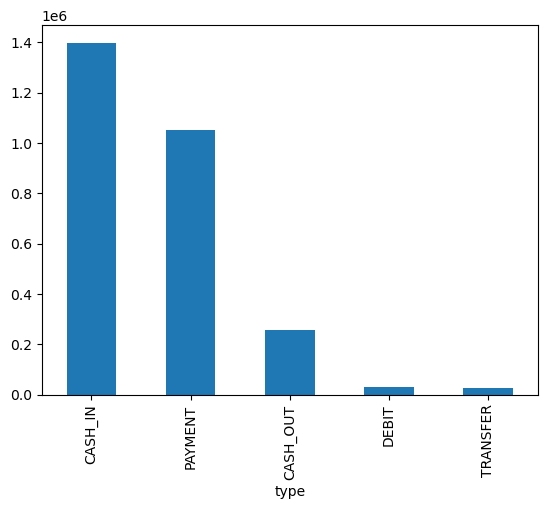

In [131]:
# transaction type distribution
df['type'].value_counts().plot(kind='bar')

<Axes: xlabel='type'>

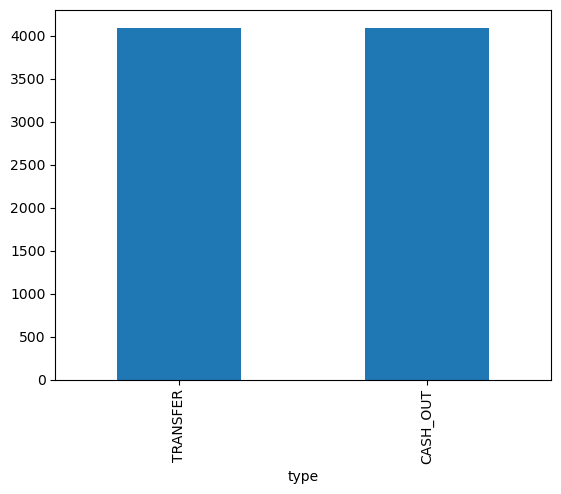

In [132]:
fraud_transaction = df[df['isFraud']==1]
fraud_transaction['type'].value_counts().plot(kind='bar')

<Axes: xlabel='isFraud', ylabel='count'>

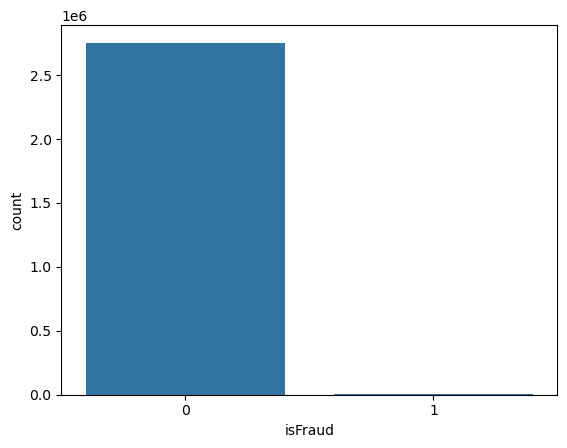

In [133]:
# class ditribution
sns.countplot(x=df['isFraud'])

In [134]:
df['isFlaggedFraud'].value_counts()

isFlaggedFraud
0    2761060
1         16
Name: count, dtype: int64

<Axes: xlabel='isFlaggedFraud', ylabel='count'>

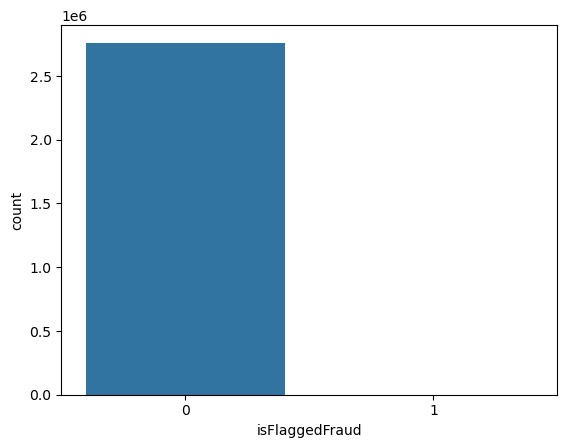

In [135]:
sns.countplot(data=df,x='isFlaggedFraud')

In [136]:
df[df['isFlaggedFraud']==1]

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour
2736446,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1,19
3247297,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1,9
3760288,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1,14
5563713,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1,2
5996407,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1,16
5996409,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1,16
6168499,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1,1
6205439,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1,9
6266413,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1,16
6281482,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1,21


<Axes: xlabel='amount', ylabel='Count'>

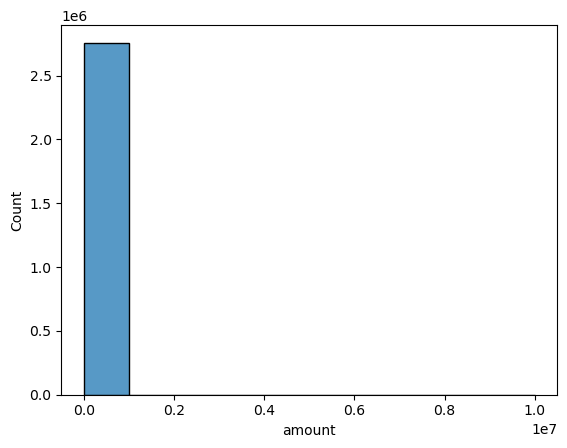

In [137]:
sns.histplot(df['amount'],bins=10)

<Axes: xlabel='newbalanceDest', ylabel='Count'>

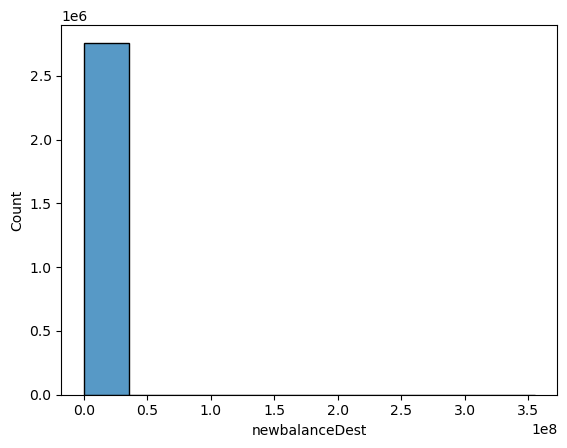

In [138]:
sns.histplot(df['newbalanceDest'],bins=10)

<Axes: xlabel='oldbalanceDest', ylabel='Count'>

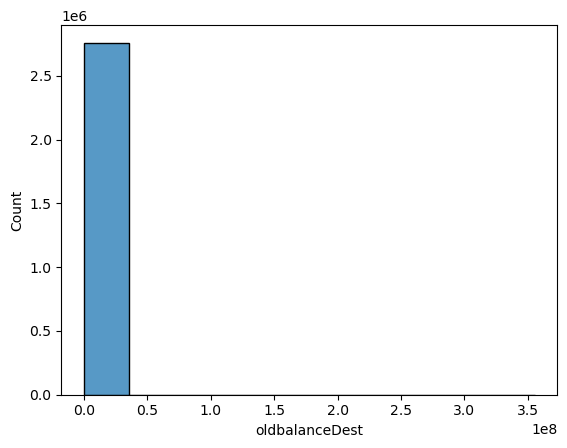

In [139]:
sns.histplot(df['oldbalanceDest'],bins=10)

<Axes: xlabel='oldbalanceOrg', ylabel='Count'>

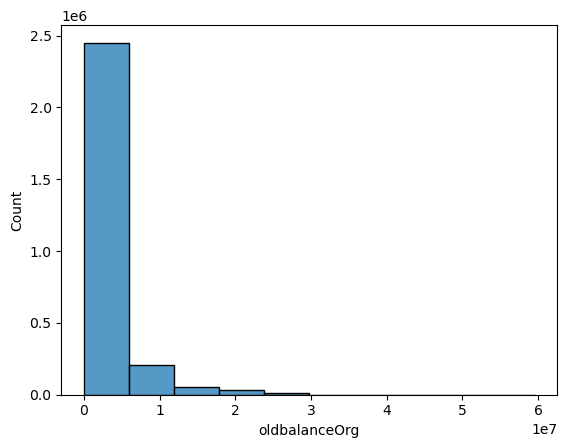

In [140]:
sns.histplot(df['oldbalanceOrg'],bins=10)

<Axes: xlabel='newbalanceOrig', ylabel='Count'>

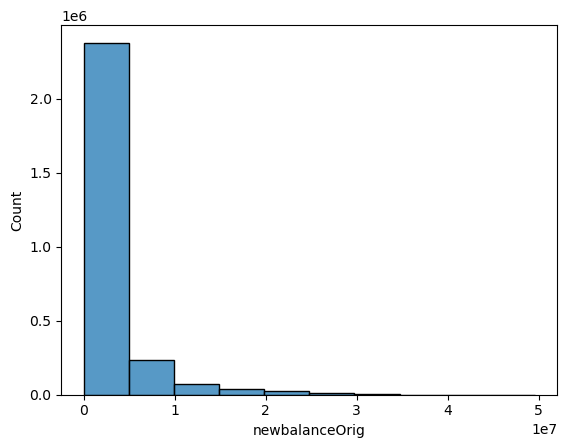

In [141]:
sns.histplot(df['newbalanceOrig'],bins=10)

In [142]:
df.corr(numeric_only=True)

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour
amount,1.000000,0.159888,0.146357,0.114910,0.119301,0.385494,0.059178,-0.070940
oldbalanceOrg,0.159888,1.000000,0.998788,0.146432,0.134428,-0.003251,0.003433,-0.021544
newbalanceOrig,0.146357,0.998788,1.000000,0.150825,0.136749,-0.023164,0.003364,-0.022558
oldbalanceDest,0.114910,0.146432,0.150825,1.000000,0.996230,-0.007249,-0.000761,-0.013472
newbalanceDest,0.119301,0.134428,0.136749,0.996230,1.000000,0.007161,-0.000724,-0.014518
isFraud,0.385494,-0.003251,-0.023164,-0.007249,0.007161,1.000000,0.044150,-0.042424
isFlaggedFraud,0.059178,0.003433,0.003364,-0.000761,-0.000724,0.044150,1.000000,-0.000943
hour,-0.070940,-0.021544,-0.022558,-0.013472,-0.014518,-0.042424,-0.000943,1.000000


<Axes: >

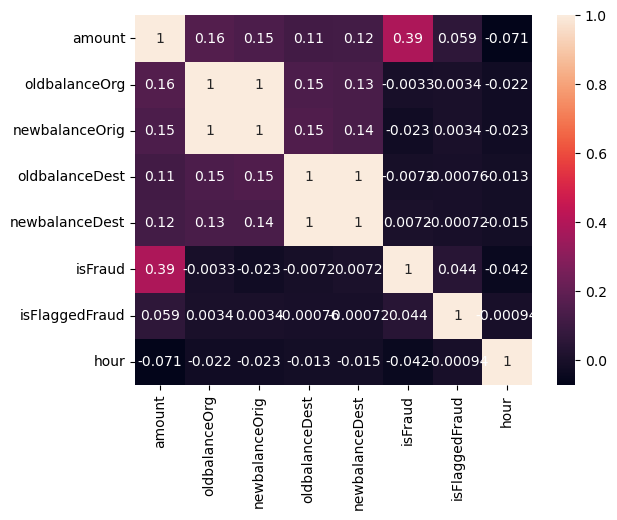

In [143]:
sns.heatmap(df.corr(numeric_only=True),annot=True)

### Separate target and independent columns

In [145]:
df_encoded = pd.get_dummies(df.drop(columns=['nameOrig','nameDest','isFraud']),columns=['type'],drop_first=True,dtype='int64')

In [146]:
df_encoded.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,hour,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,0,1,0
1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,0,1,0
2,181.00,181.0,0.00,0.0,0.0,0,0,0,0,0,1
3,181.00,181.0,0.00,21182.0,0.0,0,0,1,0,0,0
4,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,0,1,0


In [147]:
X=df_encoded
y=df['isFraud']

In [148]:
# train-test-split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

In [149]:
X_train.shape

(1932753, 11)

In [150]:
y_train.shape

(1932753,)

In [151]:
X_test.shape

(828323, 11)

In [152]:
y_test.shape

(828323,)

In [153]:
print((y_train==1).sum())
print((y_train==0).sum())

5764
1926989


In [154]:
# SMOTE balancing
sm=SMOTE(random_state=42)
X_res,y_res=sm.fit_resample(X_train,y_train)

c:\Users\kanha\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [155]:
print('before smote:',np.bincount(y_train))
print('after smote:',np.bincount(y_res))

before smote: [1926989    5764]
after smote: [1926989 1926989]


In [156]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score,accuracy_score

# XGBoost model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_res, y_res)
y_pred = xgb.predict(X_test)

C:\Users\kanha\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [01:25:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [157]:
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test,y_pred))
print('accuracy score', accuracy_score(y_test,y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    825903
           1       0.86      1.00      0.92      2420

    accuracy                           1.00    828323
   macro avg       0.93      1.00      0.96    828323
weighted avg       1.00      1.00      1.00    828323

AUC-ROC: 0.9981025266579492
accuracy score 0.9995026094892935


In [158]:
from sklearn.model_selection import cross_val_score
cross_val_score(xgb,X_res,y_res,cv=5,scoring='accuracy')

C:\Users\kanha\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [01:26:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\kanha\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [01:26:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\kanha\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [01:27:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\kanha\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [01:27:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.

array([0.99974312, 0.99973534, 0.9997561 , 0.99976518, 0.99973145])

In [159]:
# Decision tree  model
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(X_res, y_res)
y_pred1 = tree.predict(X_test)

In [160]:
print("Classification Report:")
print(classification_report(y_test, y_pred1))
print("AUC-ROC:", roc_auc_score(y_test,y_pred1))
print('accuracy score', accuracy_score(y_test,y_pred1))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    825903
           1       0.99      1.00      1.00      2420

    accuracy                           1.00    828323
   macro avg       1.00      1.00      1.00    828323
weighted avg       1.00      1.00      1.00    828323

AUC-ROC: 0.999990919030443
accuracy score 0.999981891122183


In [161]:
from sklearn.model_selection import cross_val_score
cross_val_score(tree,X_res,y_res,cv=5,scoring='accuracy')

array([0.99998962, 0.99998832, 0.99998832, 0.99998832, 0.99998573])

In [162]:
# Logistic regression  model
model= LogisticRegression()
model.fit(X_res, y_res)
y_pred2 = model.predict(X_test)

c:\Users\kanha\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [164]:
print("Classification Report:")
print(classification_report(y_test, y_pred2))
print("AUC-ROC:", roc_auc_score(y_test,y_pred2))
print('accuracy score', accuracy_score(y_test,y_pred2))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    825903
           1       0.07      0.89      0.12      2420

    accuracy                           0.96    828323
   macro avg       0.53      0.92      0.55    828323
weighted avg       1.00      0.96      0.98    828323

AUC-ROC: 0.9243431369479354
accuracy score 0.963333144196165


In [165]:
from sklearn.model_selection import cross_val_score
cross_val_score(model,X_res,y_res,cv=5,scoring='accuracy')

c:\Users\kanha\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\kanha\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

array([0.93028765, 0.92993607, 0.93043814, 0.93008906, 0.9301202 ])

In [166]:
from sklearn.metrics import confusion_matrix,precision_score
confusion_matrix(y_test,y_pred2)

array([[795809,  30094],
       [   278,   2142]], dtype=int64)

In [167]:
precision_score(y_test,y_pred2,average=None)

array([0.99965079, 0.06644745])

In [168]:
# out of all the models logistic model is the most simplest one, it may underfits according to the problem statemnt with a low precision for 1(fraud)
# the decision tree model overfits , with perfect scores
# xgboost is the best model in this scenario with very hisgh recall(for fraud cases) and a good precsion for fraud cases.
# so we will deploy the xgboost model.

### Select the best model
* out of all the models logistic model is the most simplest one, it may underfits according to the problem statemnt with a low precision for 1(fraud)
* the decision tree model overfits , with perfect scores
* xgboost is the best model in this scenario with very hisgh recall(for fraud cases) and a good precsion for fraud cases.
* so we will deploy the xgboost model.

In [169]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBClassifier())
])

pipeline.fit(X_res,y_res)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [170]:
import joblib
joblib.dump(pipeline, "fraud_detection_model.pkl")

['fraud_detection_model.pkl']

In [171]:
feature_names = list(df_encoded.columns)
joblib.dump(feature_names, "feature_names.pkl")


['feature_names.pkl']